<a href="https://colab.research.google.com/github/unoki/colabtest/blob/master/7_1dCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第7章　1次元畳み込みニューラルネットワークによる異常検知（プログラム）

第７章では、1次元畳み込みニューラルネットワークによる異常検知のプログラムを実行します。


### 学習項目

1. 準備
2. データの準備
3. モデルの定義
4. パラメータの設定
5. トレーニング
6. 評価

### 使用するファイル
- 7_1dCNN.ipynb （このファイルです）
- data/X.csv (心電図の波形データ)
- data/y.csv (正解ラベル)

### データセット

- MIT-BIH Arrhythmia Databaseで公開されている心電図データから一部を抜粋し、本セミナー用に前処理を行いました。
- 元データでRとラベルのついた波形のピークの前後１秒づつ、計２秒を切り出して一つのデータとしました。事前に標準化を行いました。
- サンプリングレート180Hzで、一つのデータは２秒分で360点からなります。
- 各データには、正常か異常かの正解ラベルがついてます。
- 波形のデータはX.csvに、対応する正解ラベルはy.csvに保存されています。
- 正解ラベルは数値が割り当てられており、0が正常、1が異常です。


# 1. 準備
###  必要なライブラリの読み込み

- NumPy：モデル入力用のデータを作成するために使用します。
- Matplotlib：データの可視化に使用します。
- keras：ニューラルネットワークのためのライブラリです。
- scikit-learn：機械学習用のライブラリです。データの分割、結果の評価に使用します。

In [0]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv1D, Dropout
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import keras.backend as K

### バックエンドのグラフ識別子をリセット

In [6]:
K.clear_session

<function keras.backend.tensorflow_backend.clear_session>

### カレントディレクトリの移動

In [7]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/Colab Notebooks/jasla_rensyuu_20190202"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/jasla_rensyuu_20190202


# 2. データの準備

### CSVファイルからデータを読み込む

- csvファイルから Pandas の DataFrame としてデータを読み込みます。
- 波形データを変数 X_df に、正解ラベルを変数 y_df に読み込んでみましょう。
- X.csvはヘッダー行を含まないファイルのため、read_csv関数のパラメータでheader=Noneを指定します。

In [0]:
x_df = pd.read_csv('data/X.csv', header=None)
y_df = pd.read_csv('data/y.csv')

### データのサイズを確認してみましょう

- データの行と列の数を確認するには、shape を使います。
- shapeは関数ではないので、カッコが不要です。

In [9]:
x_df.shape


(12260, 360)

In [10]:
y_df.shape

(12260, 1)

### データの一部を表示してみましょう

- データの一部を表示するには、head関数や、tail関数を使います。
- 他に長いデータの場合、.Tを使って転置をすると、見やすくなる場合があります。

In [11]:
y_df.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 異常値の割合を確認してみましょう
- Seriesのvalue_counts関数を使うとデータの値の出現回数を数えることができます。
- y_dfはDataFrameのなので、列を指定して Seriesとします。
- value_counts関数のnormalizeパラメータをTrueとすると、割合が分かります。

In [12]:
y_df['y'].value_counts(True)

0    0.961093
1    0.038907
Name: y, dtype: float64


### トレーニングデータとテストデータに分割

- データを訓練データと、テストデータに分けます。60％を訓練データに、40％をテストデータに使います。
- データの分割は、scikit-learnライブラリのtrain_test_splitが便利です。
- train_test_splitは、第1引数に入力データ、第2引数に正解ラベルを渡します。test_sizeではテストデータの割合を0.0～1.0の実数で指定します。
デフォルトではランダムにシャッフルして分割します。 random_stateに任意の整数を指定して、乱数のシードを固定することで、同じ分割を再現できます。
- トレーニング用データを変数x_trainとy_trainに、テスト用データを変数x_testとy_testに代入しましょう。
- 分割後のデータのサイズや、異常値の割合も確認しておきましょう。

In [0]:
x_train, x_test, y_train, y_test  = train_test_split(x_df, y_df, test_size=0.4, random_state=0)

In [14]:
x_train.shape, x_test.shape

((7356, 360), (4904, 360))

In [15]:
y_train['y'].value_counts(normalize=True)

0    0.9618
1    0.0382
Name: y, dtype: float64

In [16]:
y_test['y'].value_counts(normalize=True)

0    0.960033
1    0.039967
Name: y, dtype: float64

### 3階のテンソルへの変換
- Kerasの1次元の畳み込みレイヤーConv1Dへの入力は、Shapeが(batch_size, steps, input_dim)の3階テンソルにします。
(https://keras.io/ja/layers/convolutional/)
- reshape関数で変換をし、変換後のデータは、それぞれ変数 X_train と X_testに代入しましょう。

In [0]:
X_train = x_train.values.reshape(x_train.shape[0], x_train.shape[1], 1)
X_test =  x_test.values.reshape(x_test.shape[0], x_test.shape[1], 1)

In [18]:
X_train.shape, X_test.shape

((7356, 360, 1), (4904, 360, 1))

### 正解レベルのOne-hot表現への変換

- 正解ラベルをOne-hot表現に変換します。すなわち、0（正常）または1（異常）と１列で表現されていた正解ラベルデータを、１列目が１ならば正常、２列名が１なら異常と、2列で表現するようにします。
- Kerasのto_categorical関数を利用します。
- ２値分類問題のときには必須ではありませんが、多値分類問題のときには必要な処理になります。
- 変換後の正解ラベルデータを、y_train_cおよびy_test_cに代入しましょう。

In [0]:
n_class = 2
y_train_c = to_categorical(y_train, n_class)
y_test_c = to_categorical(y_test, n_class)

In [20]:
y_train_c.shape, y_test_c.shape

((7356, 2), (4904, 2))


# 3. モデルの定義

- KerasのSequentialモデルを使います。

- 1次元の畳み込み層は、Conv1Dです。フィルターの数と、カーネルのサイズを指定します。
- 全結合層（Dense）に渡す前に、Flattenを呼びましょう。
- Dropoutも追加できます。


In [0]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=10, input_shape=(X_train.shape[1], 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dropout(0.4)) 
model.add(Dense(128, activation='relu'))  
model.add(Dense(n_class))
model.add(Activation('softmax'))

- summary関数で、モデルのが概要を確認できます。

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 351, 64)           704       
_________________________________________________________________
activation_1 (Activation)    (None, 351, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 22464)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22464)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2875520   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total para

# 4. パラメータの設定

- compile関数を用いてどのような学習処理を行なうかを設定を行います。
- 今回は、損失関数にカテゴリカルクロスエントロピー、最適化アルゴリズムに確率的勾配降下法（SGD）を指定します。
- 細かいパラメータは、すべてデフォルトのままとしました。

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd')

# 5. トレーニング

- 入力データと教師データ（正解ラベル）を使って、モデルのトレーニング（学習）を行います。
- モデルをトレーニングには，fit関数を使います。
- fit関数には、トレーニングの入力データと教師データ、ミニバッチのサイズ(batch_size)、エポック数などを渡します。

In [24]:
epochs = 8
history = model.fit(X_train, y_train_c, epochs=epochs)

Epoch 1/8
7356/7356 [==============================] - 21s 3ms/step - loss: 0.0583
Epoch 2/8
7356/7356 [==============================] - 20s 3ms/step - loss: 0.0173
Epoch 3/8
7356/7356 [==============================] - 20s 3ms/step - loss: 0.0112
Epoch 4/8
7356/7356 [==============================] - 20s 3ms/step - loss: 0.0080
Epoch 5/8
7356/7356 [==============================] - 20s 3ms/step - loss: 0.0062
Epoch 6/8
7356/7356 [==============================] - 21s 3ms/step - loss: 0.0049
Epoch 7/8
7356/7356 [==============================] - 20s 3ms/step - loss: 0.0043
Epoch 8/8
7356/7356 [==============================] - 21s 3ms/step - loss: 0.0036


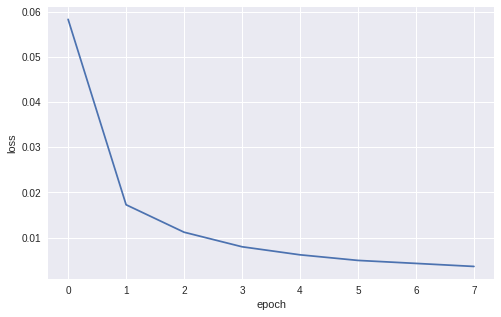

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# 6. 評価


- テストデータを使って、トレーニング済みモデルの評価を行います。


### テストデータからトレーニング済みモデルを使って予測

- predict_classes関数にテストデータを渡すことで、トレーニング済みモデルによる推定結果を得ることができます。

In [0]:
y_pred = model.predict_classes(X_test)  

### 各種評価指標の算出
- 分類問題のモデル評価には、scikit-learnの関数を使うのが便利です。
- accuracy_score関数で、正解率を算出できます。

In [27]:
accuracy_score(y_test, y_pred)

0.9991843393148451

- confusion_matrix関数で、混同行列を表示することができます。

In [28]:
confusion_matrix(y_test, y_pred)

array([[4707,    1],
       [   3,  193]])

- 下記では混同行列を見やすくするためのpretty_confusion_matrix関数を定義しました。

In [29]:
def pretty_confusion_matrix(y_true, y_pred, labels=["False", "True"]):
    cm = confusion_matrix(y_true, y_pred)
    pred_labels = ['Predicted '+ l for l in labels]
    df = pd.DataFrame(cm, index=labels, columns=pred_labels)
    return df

pretty_confusion_matrix(y_test, y_pred, ['Normal', 'Abnormal'])

,Predicted Normal,Predicted Abnormal
Normal,4707,1
Abnormal,3,193


- classification_report関数では、精度 (Precision)や、検出率 (Recall) を表示することができます。

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4708
           1       0.99      0.98      0.99       196

   micro avg       1.00      1.00      1.00      4904
   macro avg       1.00      0.99      0.99      4904
weighted avg       1.00      1.00      1.00      4904

